# STM Modelling 

In [6]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib

In [12]:
data = pd.read_csv("./CSVFiles/data.csv").drop(columns=["Unnamed: 0"])
data.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [13]:
stations = pd.read_csv("./CSVFiles/stations.csv").drop(columns=["Unnamed: 0"])
stations.head()

,Station ID,Capacity,Latitude,Longitude,Station Name
0,1,19,51.529163,-0.109970,"River Street , Clerkenwell"
1,2,37,51.499606,-0.197574,"Phillimore Gardens, Kensington"
2,3,32,51.521283,-0.084605,"Christopher Street, Liverpool Street"
3,4,23,51.530059,-0.120973,"St. Chad's Street, King's Cross"
4,5,27,51.493130,-0.156876,"Sedding Street, Sloane Square"


In [14]:
trips = pd.read_csv("./CSVFiles/trips.csv").drop(columns=["Unnamed: 0"])
trips.head()

,ID,StartStationID,EndStationID,Duration,StartDate,EndDate
0,1,39,32,2,2011-01-01 00:55:00,2011-01-01 00:57:00
1,2,13,5,11,2011-01-01 00:28:00,2011-01-01 00:39:00
2,3,21,27,32,2010-12-31 23:39:00,2011-01-01 00:11:00
3,4,12,13,3,2011-01-01 00:07:00,2011-01-01 00:10:00
4,5,5,6,22,2011-01-01 00:07:00,2011-01-01 00:29:00


## Feature Selection
### Correlation maps between weather, time and count of bikes BY HOUR

/tmp/ipykernel_39961/1899571812.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(features.corr(),square=True, vmin=-1, vmax=1, annot=True, linewidths=.5)


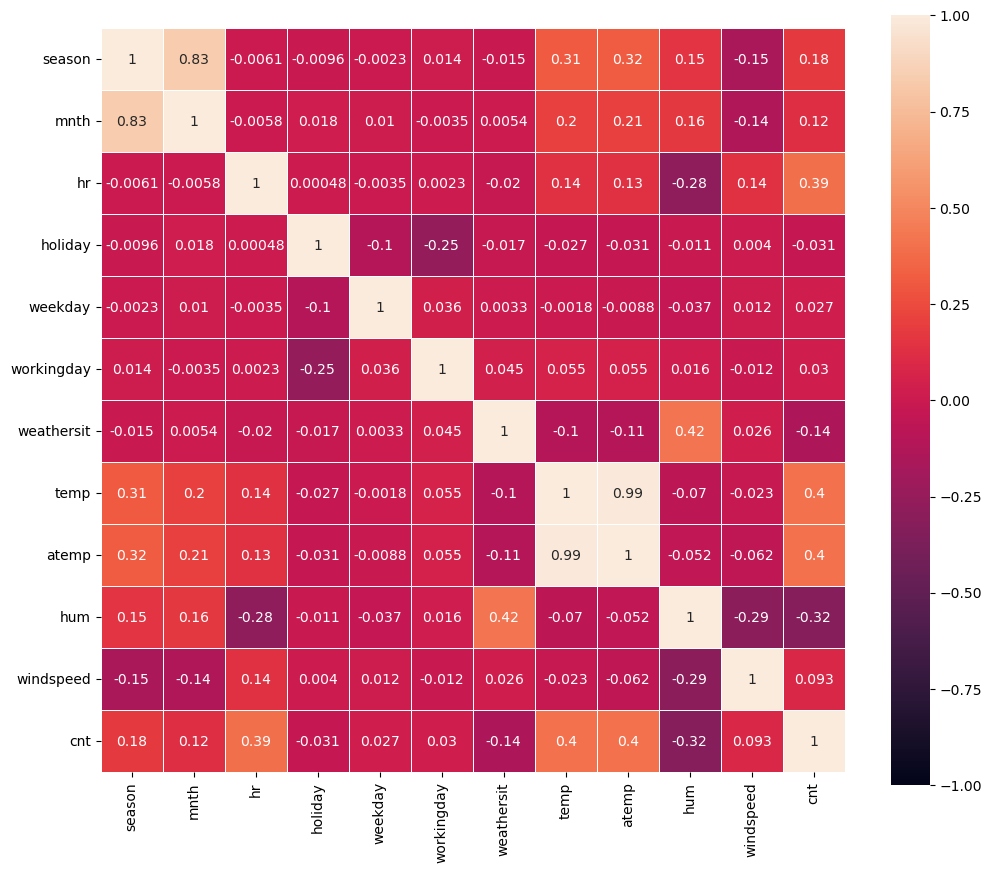

In [48]:
features = data.drop(columns=["yr"])

fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(features.corr(),square=True, vmin=-1, vmax=1, annot=True, linewidths=.5)

With this we understand that the number of bikes rented depends more on the season, month, hour, temperature and temperature feeling, based on the hours.

We can also see that temp or atemp is the same thing so we can drop one of them, nad have less features.

In [51]:
features = data.drop(columns=["holiday", "weekday", "workingday", "weathersit", "hum", "windspeed", "atemp", "yr"])
features.head()

,dteday,season,mnth,hr,temp,cnt
0,2011-01-01,1,1,0,0.24,16
1,2011-01-01,1,1,1,0.22,40
2,2011-01-01,1,1,2,0.22,32
3,2011-01-01,1,1,3,0.24,13
4,2011-01-01,1,1,4,0.24,1


### Correlation maps between weather, time and count of bikes BY DAY

In [52]:
data_day = []
visited_day = []
for dt in data.values:
    day = dt[0]
    if day in visited_day:
        continue

    visited_day.append(day)

    information = {"dteday": day, "season": dt[1], "yr": dt[2], "mnth": dt[3], "hr": dt[4], "holiday": dt[5], "weekday": dt[6], "workingday": dt[7], "weathersit": 0, "temp": 0, "atemp": 0, "hum": 0, "windspeed": 0, "cnt": 0}
    for info in data.loc[data["dteday"] == day].values:
        information["weathersit"] += info[8]
        information["temp"] += info[9]
        information["atemp"] += info[10]
        information["hum"] += info[11]
        information["windspeed"] += info[12]
        information["cnt"] += info[-1]

    information["weathersit"] /= 24
    information["temp"] /= 24
    information["atemp"] /= 24
    information["hum"] /= 24
    information["windspeed"] /= 24
    information["cnt"] += info[-1]

    data_day.append(information)

data_day = pd.DataFrame(data_day)
data_day.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1.583333,0.344167,0.363625,0.805833,0.160446,1024
1,2011-01-02,1,0,1,0,0,0,0,1.875000,0.348333,0.339000,0.667083,0.238183,809
2,2011-01-03,1,0,1,0,0,1,1,0.916667,0.180000,0.173621,0.400833,0.227617,1361
3,2011-01-04,1,0,1,0,0,2,1,1.000000,0.191667,0.203283,0.565833,0.153617,1573
4,2011-01-05,1,0,1,0,0,3,1,0.958333,0.217500,0.219717,0.418750,0.179113,1619


/tmp/ipykernel_39961/365110739.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(features_day.corr(),square=True, vmin=-1, vmax=1, annot=True, linewidths=.5)


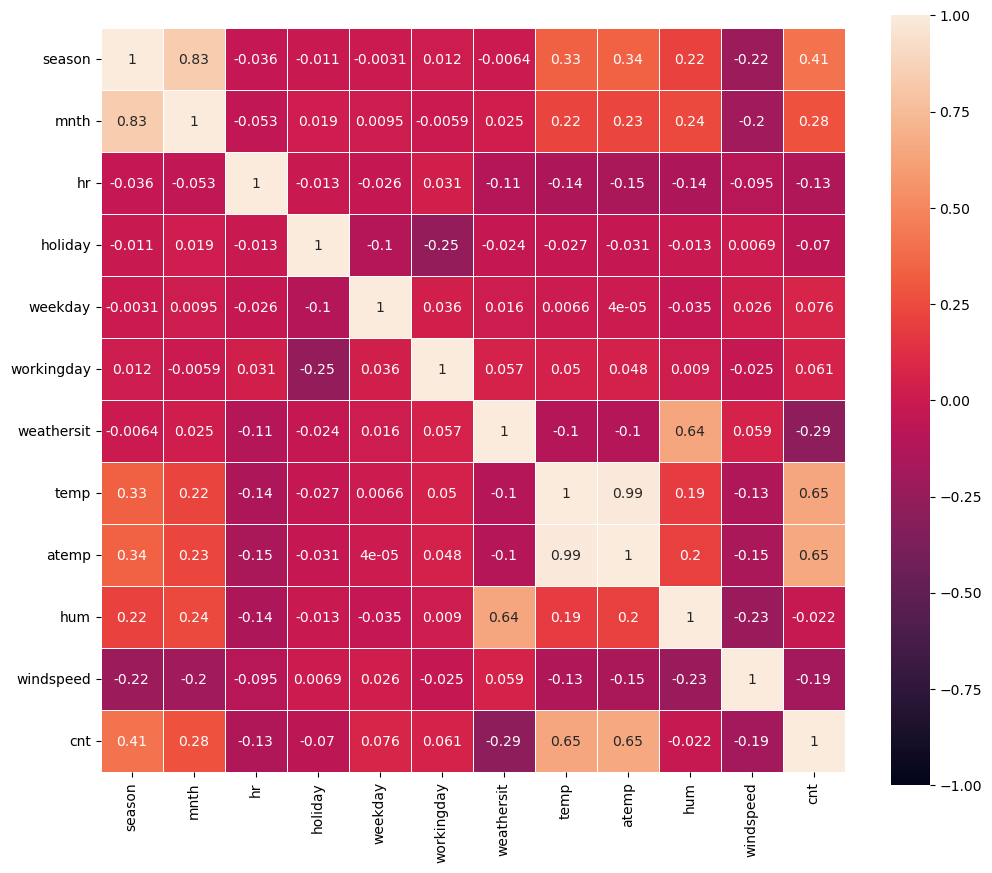

In [53]:
features_day = data_day.drop(columns=["yr"])

fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(features_day.corr(),square=True, vmin=-1, vmax=1, annot=True, linewidths=.5)

With this we understand that the number of bikes rented depends more on the season, month, temperature and temperature feeling, based on the days.

We can also see that temp or atemp is the same thing so we can drop one of them, nad have less features.

(array([1024.,  809., 1361., 1573., 1619., 1629., 1525.,  981.,  828.,
        1339., 1282., 1182., 1421., 1448., 1292., 1222., 1004.,  703.,
        1678., 1958., 1570., 1014., 1007., 1440., 2025.,  532.,  447.,
        1190., 1131., 1117., 1518., 1376., 1558., 1588., 1739., 1064.,
        1653., 1737., 1542., 1642., 1572., 1799., 1504., 1619., 1933.,
        1835., 2148., 2519., 3004., 1664., 1866., 1109., 1471., 1956.,
        1857., 1500., 2003., 2461., 1491., 1876., 2156., 1708., 1990.,
        2121.,  614., 1894., 2174., 1909.,  650., 2014., 2181., 2445.,
        2065., 2074., 2219., 2794., 3325., 3167., 2495., 2107., 2735.,
        2147., 1898., 2249., 2537., 1712., 2047., 2460., 1548., 1712.,
        2280., 2305., 3280., 3163., 1821., 2848., 3195., 1506., 2512.,
        2927., 3402., 2073., 2224., 3314., 3190.,  830., 3800., 3475.,
        3256., 4037., 4288., 1700., 4153., 4233., 4135., 4478., 3950.,
        4168., 4708., 5437., 3497., 4465., 4513., 2690., 4548., 4728.,
      

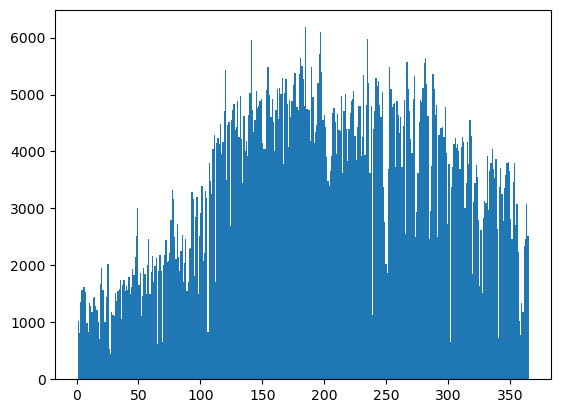

In [59]:
days = {x:0 for x in range(1,366)}

count = 1
for t in features_day.values:
    if count > 365:
        break
    days[count] += t[-1]
    count += 1

plt.hist(list(range(1,366)), len(days), weights=list(days.values()))

(array([137289., 154073., 232595., 273797., 338236., 353797., 353103.,
        358633., 352607., 328407., 259387., 214760.]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        ]),
 <BarContainer object of 12 artists>)

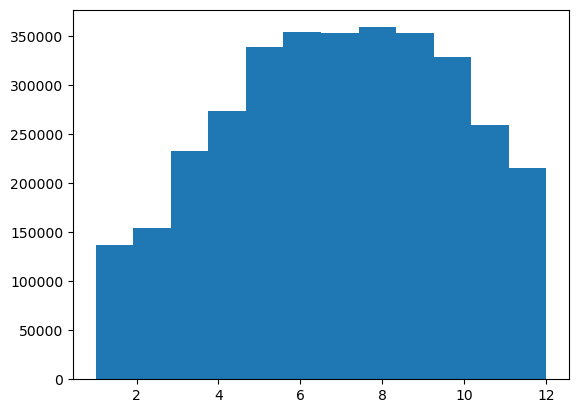

In [65]:
months = {x:0 for x in range(1,13)}

for t in features_day.values:
    months[t[2]] += t[-1]

plt.hist(list(range(1,13)), len(months), weights=list(months.values()))

(array([ 479368.,  936250., 1084131.,  856935.]),
 array([1.  , 1.75, 2.5 , 3.25, 4.  ]),
 <BarContainer object of 4 artists>)

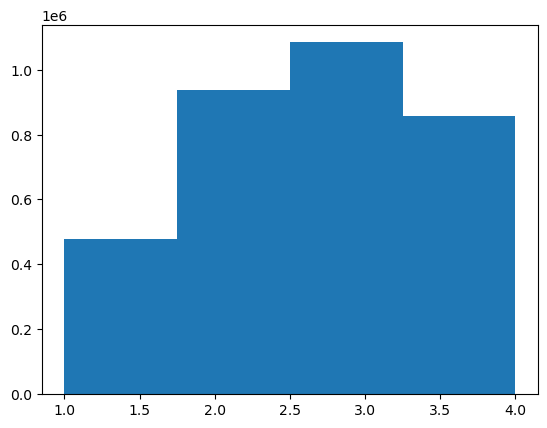

In [66]:
seasons = {x:0 for x in range(1,5)}

for t in features_day.values:
    seasons[t[1]] += t[-1]

plt.hist(list(range(1,5)), len(seasons), weights=list(seasons.values()))

## Model

/tmp/ipykernel_39961/2191056405.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(features.corr(),square=True, vmin=-1, vmax=1, annot=True, linewidths=.5)


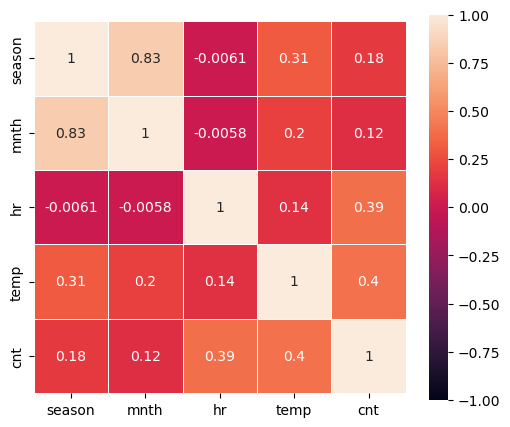

In [68]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(features.corr(),square=True, vmin=-1, vmax=1, annot=True, linewidths=.5)